# Unsupervised learning

## Import necessary libraries

In [5]:
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import set_config
set_config(transform_output="pandas")

## Prepare dataset

In [7]:

songs_df = pd.read_csv("3_spotify_5000_songs.csv")

# to strip the spaces in column names and in columns "artist" and "name"
songs_df.columns = songs_df.columns.str.strip()

songs_df["artist"] = songs_df["artist"].str.strip()
songs_df["name"] = songs_df["name"].str.strip()

songs_df = songs_df.set_index(["artist","name"])
songs_df = songs_df.drop(columns=['Unnamed: 0', 'id', 'html', "type", "key", "mode","duration_ms","time_signature"] )


## Next Step Logic


At some moment we understand the inefficiency of manually iterating through parameter combinations, the goal is to establish a robust analytical pipeline that efficiently evaluates the impact of various techniques—specifically scaling, n-clusters selection, and Principal Component Analysis (PCA)—on clustering performance. The core functionality is implemented through a series of Python functions designed to:

1. Loop through defined ranges of parameters (scalers, n-clusters, and PCA components).

2. Generate and store lists of performance metrics, namely Inertia and Silhouette Score.

3. Visualise these metrics through comprehensive charts for all scaler types.

4. Identify and visualise "silhouette peaks" to define the most promising parameter combinations for optimal cluster separation.

Declare the scalers

In [8]:
# To define the scalers and put them into one list
min_max_scaling = MinMaxScaler()
stds_scaling = StandardScaler()
rbst_scaling = RobustScaler()

scale_list = [min_max_scaling, stds_scaling, rbst_scaling]

Prepare the function which draws inertia and silhouette scores

In [ ]:

def draw_inertia_silhoette_charts(inertia_list, silhouette_list, scaler_name, min = 0, max = 0):
    import matplotlib.pyplot as plt
    import numpy as np

    min = 0
    max_i= len(inertia_list)
    max_s= len(silhouette_list)


    if max_i < max_s:
        max= max_i
    else: max = max_s
    
   # to recogniye the scaler
    if scaler_name == "MinMax" or scaler_name == "Robust":
        
        # x-axis
        x_axis_data = np.arange(min, max)
                
        #two other axis
        inertia_data = inertia_list[min:max]
        silhouette_data = silhouette_list[min:max] 
        print(f"{scaler_name} have done, x = {min, max}, ")        

    elif scaler_name == "Standart":

        x_axis_data = np.arange(min, max_i-1)

        inertia_data = inertia_list[min:max_i-1]   
        silhouette_data = silhouette_list[min:max_i] 
        print(f"{scaler_name} have done, x = {min, max}, ")

    elif  scaler_name == "Robust":
            
        x_axis_data = np.arange(min, max)
                
        inertia_data = inertia_list[min:max]
        silhouette_data = silhouette_list[min:max]
        print(f"{scaler_name} have done, x = {min, max}, ")
    

    # --- Create the Dual-Axis Chart ---

    # 1. Create the figure and the primary axes (ax1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 2. Set up the primary axis (Left Y-axis) for Inertia
    color = 'tab:red'
    ax1.set_xlabel('Index (k-value)')
    ax1.set_ylabel('Inertia (Left Axis)', color=color)
    line1, = ax1.plot(x_axis_data, inertia_data, color=color, marker='o', label='Inertia')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # 3. Create the secondary axes (ax2) sharing the same X-axis
    ax2 = ax1.twinx()

    # 4. Set up the secondary axis (Right Y-axis) for Silhouette
    color = 'tab:blue'
    ax2.set_ylabel('Silhouette Score (Right Axis)', color=color)
    line2, = ax2.plot(x_axis_data, silhouette_data, color=color, marker='x', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # 5. Add a Title and Legend
    fig.suptitle(f'Inertia and Silhouette Scores on a Dual-Axis Chart, {scaler_name}')
    # Combine legends from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # 6. Adjust layout and save the figure with a transparent background
    fig.tight_layout()
    plt.savefig(f'dual_axis_chart_{scaler_name}_{max_i}.png'
                # , transparent=True if you would like to make charts transparent for presentation
                )

Function for calculating the inertia and silhouette score

In [ ]:

def scaler_inertia_silhouette_score_calc(df, scale_list, n_cluster_, pca_):
    """
    To calculating inertia and silhouette scores for each scaler
    Function returns the list of 6 lists: 
    The order of lists:
    indexes 0-1 => MinMaxScaler ([0] - inertia, [1] - silhoette)
    indexes 2-3 => StandartScaler ([2] - inertia, [3] - silhoette)
    indexes 4-5 => RobustScaler ([4] - inertia, [5] - silhoette)
    """
    # If number of clusters is more than 200, this statement will reduce the time to calculate
    # for n_clusters = 500 on df.shape[0] = 5325, the function will calculate approximately 15 min
    # with this step - 2 min 51 sec... BUT THIS REDUCTION WILL CHANGE THE NEXT-STEPS LOGIC
    
    step = 1
    # if n_cluster_ > 200:
    #     step = int(n_cluster_*0.01)

    pca = PCA(pca_)
    scaled_score_lists = []

    #create the loop through scalers
    for scale in scale_list:
        scaled_songs = scale.fit_transform(df)
        pca_scaled_songs = pca.fit_transform(scaled_songs)
        inertia_score_list = []
        

        # inertia calculations
        for cl in range(2, n_cluster_+1, step):
            kmeans_model = KMeans(n_clusters=cl, random_state=42)
            kmeans_model.fit(pca_scaled_songs)
            inertia_score_list.append(kmeans_model.inertia_)

        # Silhoette calculations
        silhouette_score_list = []
        for cl in range (2, n_cluster_, step):
            kmeans_model = KMeans(n_clusters=cl, random_state=42)
            kmeans_model.fit(pca_scaled_songs)
            labels = kmeans_model.labels_
            current_silhouette_score = silhouette_score(pca_scaled_songs, labels)
            silhouette_score_list.append(current_silhouette_score)
        
        # store everything
        scaled_score_lists.append(inertia_score_list)
        scaled_score_lists.append(silhouette_score_list)
   
    # The order of lists in "scaled_score_lists":
    #indexes 0-1 => MinMaxScaler ([0] - inertia, [1] - silhoette)
    #indexes 2-3 => StandartScaler ([2] - inertia, [3] - silhoette)
    #indexes 4-5 => RobustScaler ([4] - inertia, [5] - silhoette)

    # to draw inertia-silhouette charts for each scaler
    for i in range(len(scaled_score_lists)):
        if i % 2 == 0:
            if i < 2 :
                draw_inertia_silhoette_charts(scaled_score_lists[i], scaled_score_lists[i+1], "MinMax")
            elif i < 4:
                draw_inertia_silhoette_charts(scaled_score_lists[i], scaled_score_lists[i+1], "Standart")
            else:
                draw_inertia_silhoette_charts(scaled_score_lists[i], scaled_score_lists[i+1], "Robust")
        else: 
            continue

    return scaled_score_lists

Call the function to calculate and draw all charts

MinMax have done, x = (0, 498), 
Standart have done, x = (0, 498), 
Robust have done, x = (0, 498), 


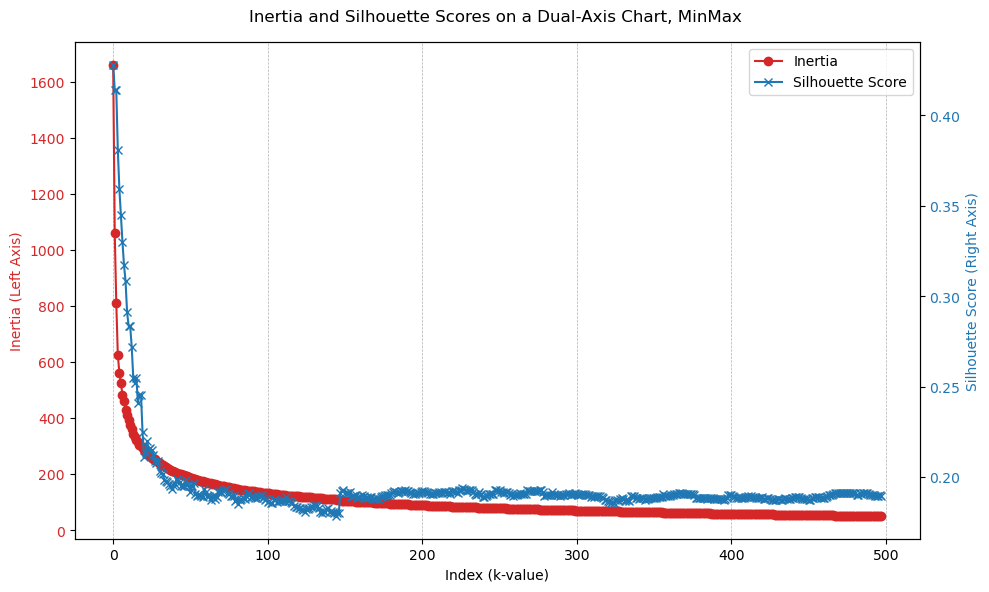

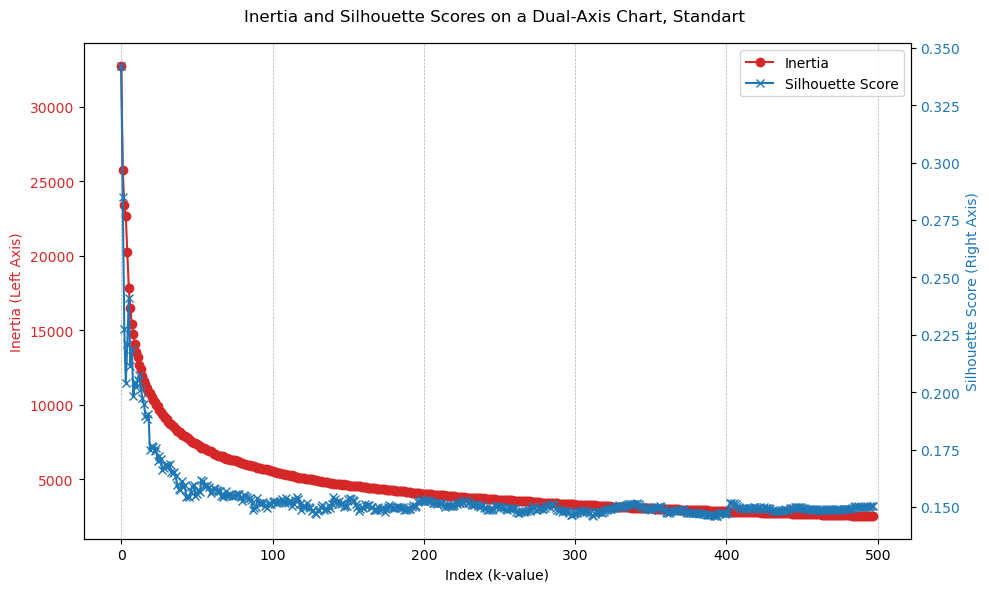

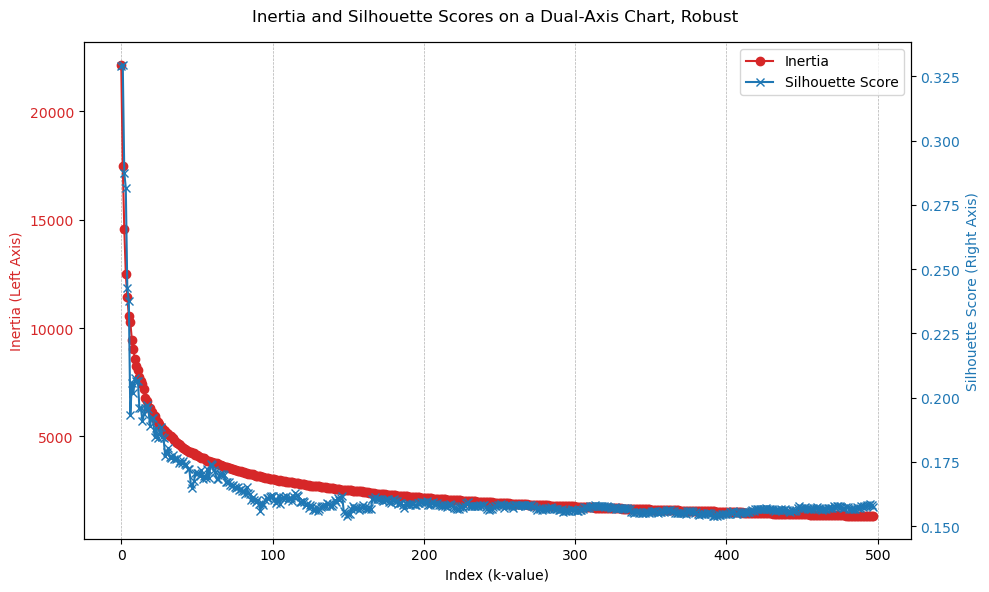

In [54]:
inert_silh_dict_500cl = scaler_inertia_silhouette_score_calc(songs_df, scale_list, 500, 0.9324643658582555)

A function which calculates silhouette peaks

In [50]:
def find_peaks_solhouette_(silhoette_list):
    import statistics
    
    peaks_list = []
    differences_list = []
    result_list = []

    for i in range(len(silhoette_list)-1):
        if silhoette_list[i]-silhoette_list[i+1] < 0:
            differences_list.append(silhoette_list[i]-silhoette_list[i+1])
            peaks_list.append(i)

    return pd.DataFrame(differences_list, peaks_list)

Draw all charts with peaks

In [ ]:

def draw_inertia_silhoette_chart_(inertia_list, silhouette_list, scaler_name, min = 0, max = 0):
    import matplotlib.pyplot as plt
    import numpy as np
        
    x_axis_data = np.arange(min, max)
                    
    inertia_data = inertia_list[min:max]
    silhouette_data = silhouette_list[min:max] 

    # --- Create the Dual-Axis Chart ---

    # 1. Create the figure and the primary axes (ax1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 2. Set up the primary axis (Left Y-axis) for Inertia
    color = 'tab:red'
    ax1.set_xlabel('Index (k-value)')
    ax1.set_ylabel('Inertia (Left Axis)', color=color)
    line1, = ax1.plot(x_axis_data, inertia_data, color=color, marker='o', label='Inertia')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # 3. Create the secondary axes (ax2) sharing the same X-axis
    ax2 = ax1.twinx()

    # 4. Set up the secondary axis (Right Y-axis) for Silhouette
    color = 'tab:blue'
    ax2.set_ylabel('Silhouette Score (Right Axis)', color=color)
    line2, = ax2.plot(x_axis_data, silhouette_data, color=color, marker='x', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # 5. Add a Title and Legend
    fig.suptitle(f'Inertia and Silhouette Scores on a Dual-Axis Chart, {scaler_name}, {min}-{max}')
    # Combine legends from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # 6. Adjust layout and save the figure with a transparent background
    fig.tight_layout()
    plt.savefig(f'dual_axis_chart_{scaler_name}_{min}_{max}.png'
                # , transparent=True if you would like to make charts transparent for presentation
                )

Combine these two functions for calculating and drawing peaks

In [ ]:
# !!!! Sometimes, if your silhouette peaks are closer to sampling boundaries draw_inertia_silhoette_chart_ function can return the error:
# x and y must have same first dimension, but have shapes (*,) and (*,)
# in these case change the lower_border and upper_border params to choose a smaller range


def draw_peaks(dict_500, lower_border=20, upper_border=20):
    silhoette_peaks_lists = []
    for index in range(len(dict_500)):
        if index % 2 == 0:
            df = find_peaks_solhouette_(dict_500[index+1])
            min_silhoette_df = df.iloc[:, 0].sort_values().head(5)
            index_min_silhoette_list = list(min_silhoette_df.index)
            sorted_silhoette_list = sorted(index_min_silhoette_list)
            list_of_indexes = [sorted_silhoette_list[-1]]

            silhoette_peaks_lists.append(list_of_indexes)

            for i in range(len(sorted_silhoette_list)-1, -1, -1):
                if (sorted_silhoette_list[i] - sorted_silhoette_list[i-1]) > 20:
                    list_of_indexes.append(sorted_silhoette_list[i-1])

            for i in list_of_indexes:
                if i > 20:
                    if index < 2:
                        draw_inertia_silhoette_chart_(dict_500[index], dict_500[index+1],"MinMax", i-lower_border, i+upper_border)
                    elif index < 4:
                        draw_inertia_silhoette_chart_(dict_500[index], dict_500[index+1],"Standart", i-lower_border, i+upper_border)
                    else:
                        draw_inertia_silhoette_chart_(dict_500[index], dict_500[index+1],"Robust", i-lower_border, i+upper_border)
    return silhoette_peaks_lists

[[146, 58, 21], [52, 8], [165, 58, 22]]

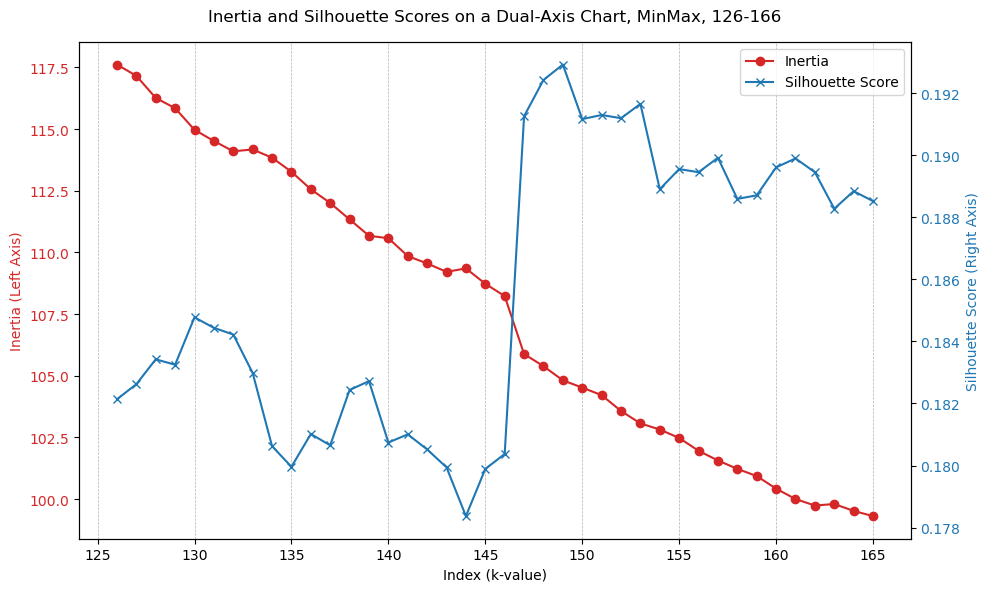

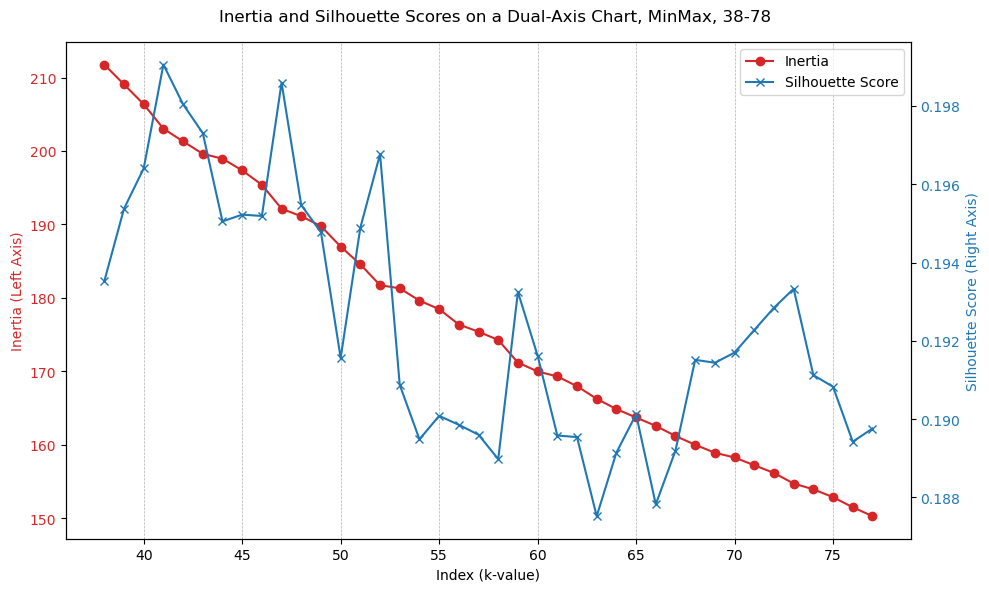

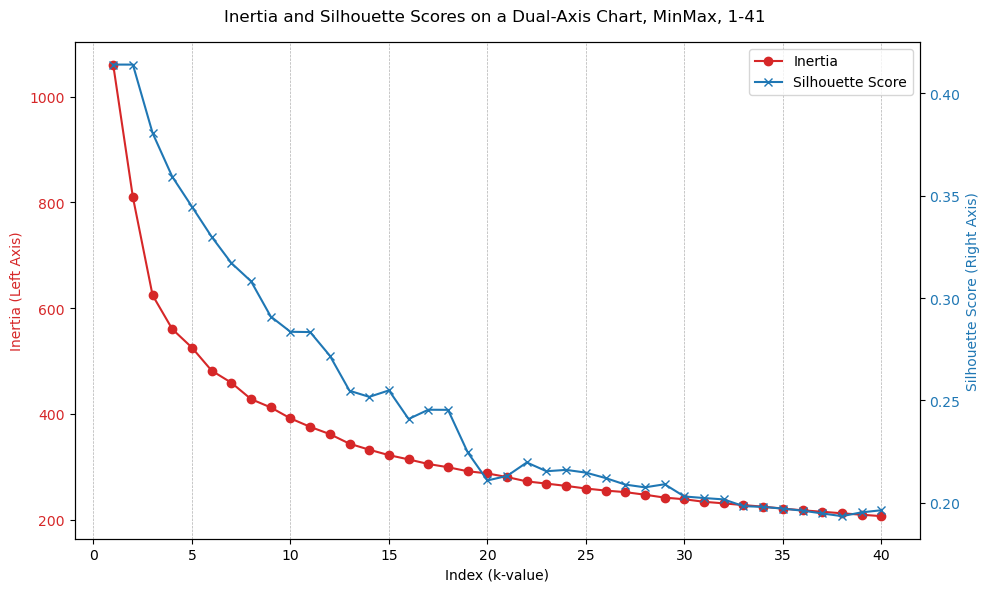

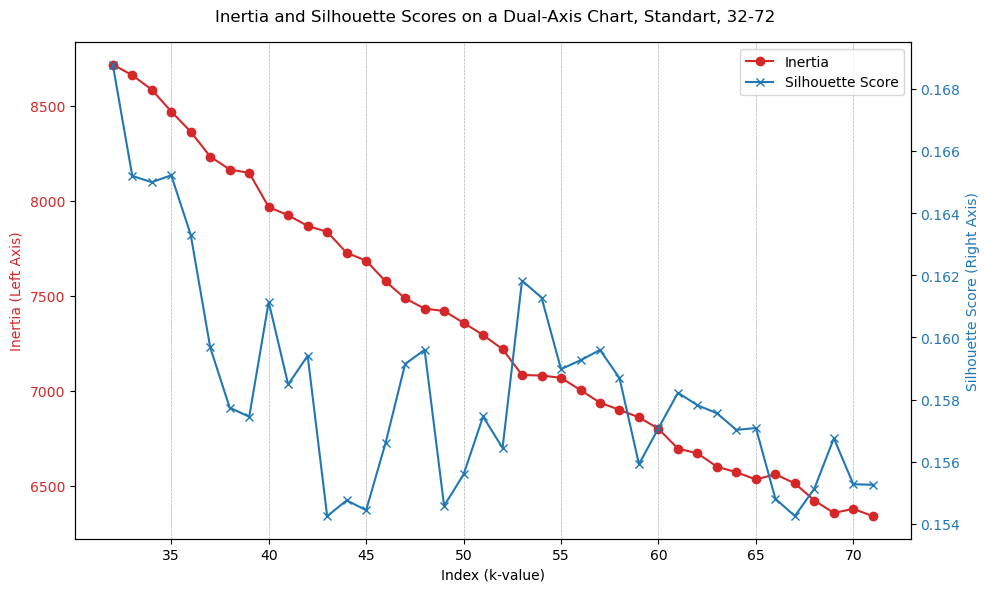

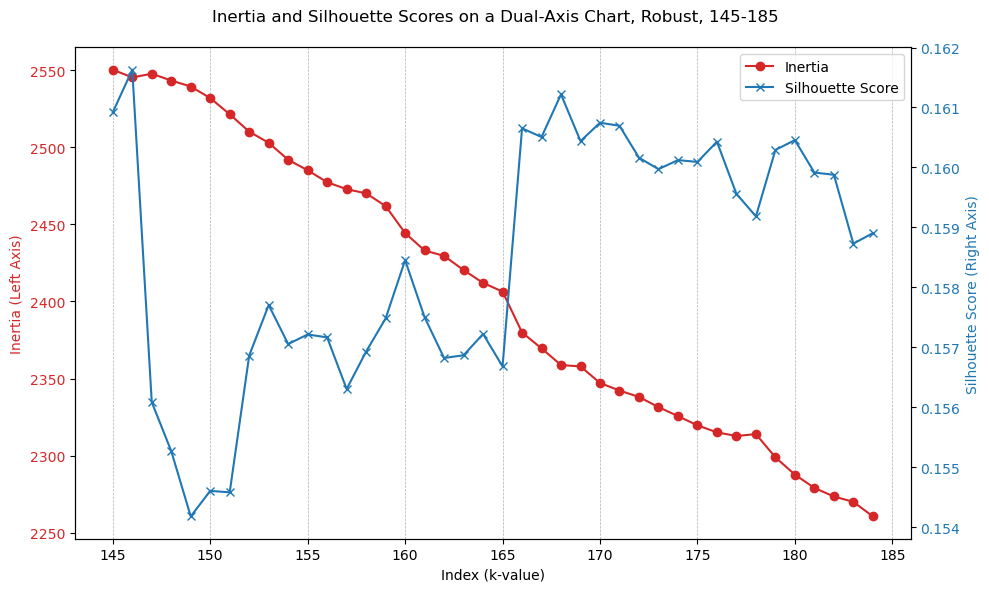

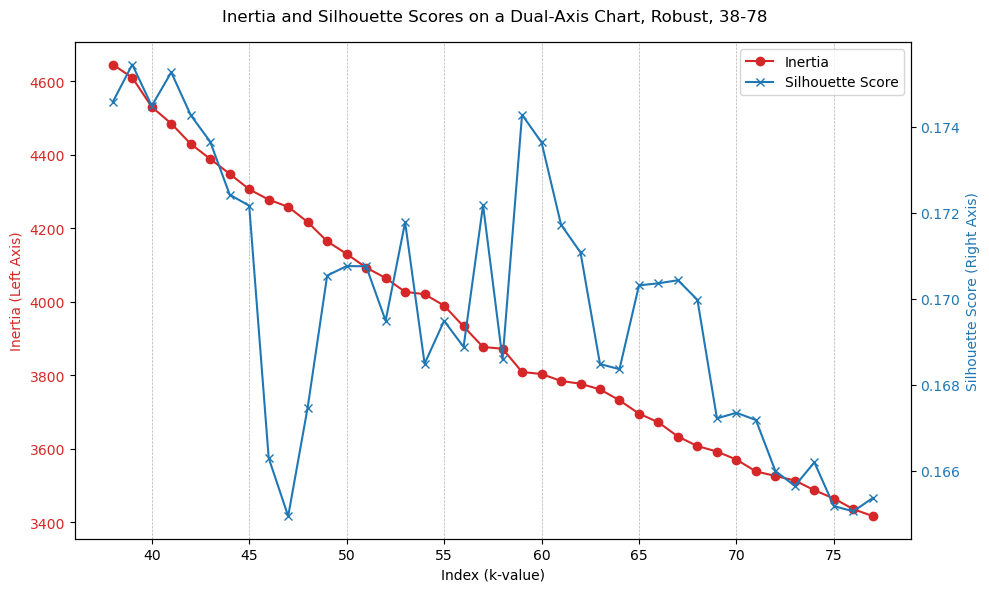

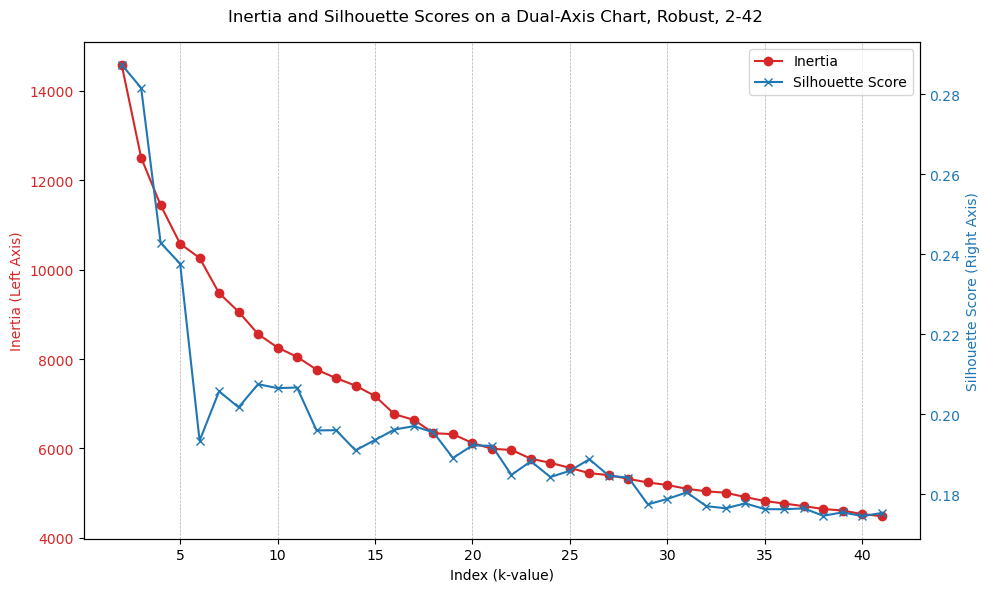

In [55]:
draw_peaks(inert_silh_dict_500cl)

MinMax have done, x = (126, 166)

MinMax have done, x = (38, 78), 

MinMax have done, x = (1, 41), 

Standart have done, x = (32, 72), 

Robust have done, x = (145, 185), 

Robust have done, x = (38, 78), 

Robust have done, x = (2, 42), 

As we can see on the charts we can assume that the optimal number of clusters can be 146, in area between 52 and 58, and between 21 and 22. The last one we will throw it away, but with the clusters number 146 and 54 we will go deeper

Calculation for 54 clusters (playlists)

In [208]:
pca = PCA(0.9324643658582555)

kmeans_model = KMeans(n_clusters=54, random_state=42)
scaled_songs = min_max_scaling.fit_transform(songs_df)
pca_scaled_songs_cl54 = pca.fit_transform(scaled_songs)
kmeans_model.fit(pca_scaled_songs_cl54)
kmeans_model.labels_

pca_scaled_songs_cl54["playlist"] = kmeans_model.labels_

pca_scaled_songs_cl54.to_csv("cluster_54(pca.932464,mmscaler).csv")

playlist_1_8_mask = (pca_scaled_songs_cl54["playlist"] == 1) | (pca_scaled_songs_cl54["playlist"] == 8)
plst_analysis_54_df = pca_scaled_songs_cl54.loc[playlist_1_8_mask]
plst_analysis_54_df.to_csv("cluster_54_PCA_0.93.csv")

From the received list of playlist we choose two (№ 1 and 8) and try to analyse styles and genres with Gemini and Chat GPT LLM 

In [209]:
plst_analysis_54_df

,,pca0,pca1,pca2,pca3,pca4,playlist
artist,name,,,,,,
Grupo De Expertos Solynieve,La Nueva Reconquista de Graná,0.377525,0.261125,0.301421,0.125747,-0.305242,8
DB Boulevard,Point of View - Radio Edit,-0.336470,-0.038042,-0.042381,-0.106032,-0.224864,1
Beach Beach,Plants,-0.125869,0.503819,0.490183,0.250998,-0.044187,8
Woods,Cali in a Cup,-0.316206,0.031261,-0.109026,0.068515,-0.194487,1
The Libertines,Don't Look Back into the Sun,-0.375717,0.130876,-0.135017,0.183001,-0.083471,1
...,...,...,...,...,...,...,...
Evvie McKinney,Just Like God,-0.220647,0.068325,-0.283122,0.054033,-0.090920,1
Jonathan Traylor,Lifted,-0.437463,0.054626,-0.081503,0.013886,-0.020457,1
Kanye West,Follow God,-0.450818,0.143229,-0.143333,-0.064218,-0.215398,1


In [210]:
pca_scaled_songs_cl54 = pd.read_csv("plst_analysis_1-8.csv")
pca_scaled_songs_cl54

,name,artist,style,Genre,PLST
0,La Nueva Reconquista de Graná,Grupo De Expertos Solynieve,Indie Rock (Spanish),Rock,8
1,Plants,Beach Beach,Indie Pop / Rock,Rock,8
2,Talking Backwards,Real Estate,Indie Rock,Rock,8
3,Mk Love Triangle,Kim,Indie Pop,Indie Pop,8
4,Nothing To Be Done,The Pastels,Indie Pop / Jangle Pop,Indie Pop,8
...,...,...,...,...,...
184,Just Like God,Evvie McKinney,Gospel Pop,Pop,1
185,Lifted,Jonathan Traylor,Gospel Pop,Pop,1
186,Follow God,Kanye West,Hip-Hop / Gospel,Hip-Hop,1
187,Happy - Live/Remastered,Tasha Cobbs Leonard,Gospel,Gospel,1


Drawoing histogramm to understand spread betwee genres and styles

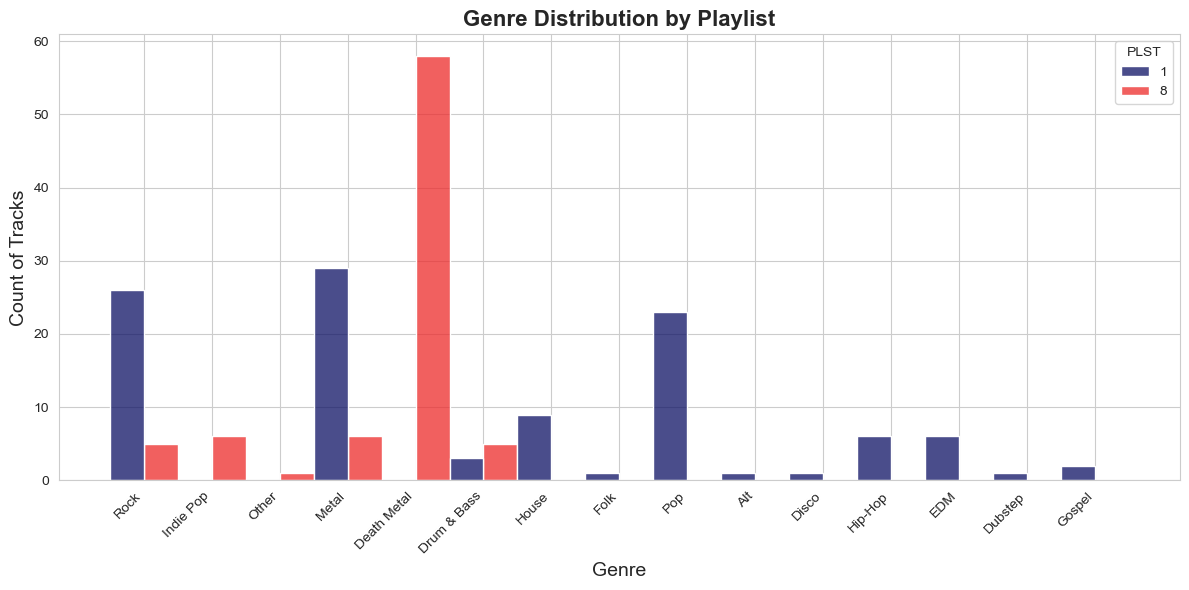

In [ ]:
custom_palette = ["#0D1164", "#ED2B2A"]

plt.figure(figsize=(12, 6), facecolor=None) 
sns.set_style("whitegrid") 
sns.histplot(
    data=pca_scaled_songs_cl54,
    x="Genre",
    hue="PLST",
    palette=custom_palette,
    multiple="dodge", 
)

plt.gca().set_facecolor('none')

plt.title("Genre Distribution by Playlist", fontsize=16, fontweight='bold')
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Count of Tracks", fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('genre_distribution_cl54.png', transparent=True)

plt.show()

Calculation for 146 clusters (playlists)

In [213]:
pca = PCA(0.9324643658582555)

kmeans_model = KMeans(n_clusters=146, random_state=42)
scaled_songs = min_max_scaling.fit_transform(songs_df)
pca_scaled_songs_cl146 = pca.fit_transform(scaled_songs)
kmeans_model.fit(pca_scaled_songs_cl146)
kmeans_model.labels_

pca_scaled_songs_cl146["playlist"] = kmeans_model.labels_

pca_scaled_songs_cl146.to_csv("cluster_146(pca.932464,mmscaler).csv")

pca_scaled_songs_cl146

,,pca0,pca1,pca2,pca3,pca4,playlist
artist,name,,,,,,
Gilberto Gil,Se Eu Quiser Falar Com Deus,0.240558,-0.505039,-0.273882,0.527027,0.602449,50
Antônio Carlos Jobim,Saudade De Bahia,-0.208316,-0.383904,0.091799,-0.170560,0.021825,95
Martinho Da Vila,"Canta Canta, Minha Gente",-0.328660,-0.471112,0.285064,-0.003210,0.023552,136
Chico César,Mulher Eu Sei,0.383740,-0.816332,-0.078838,0.106741,0.216193,139
Kurt Elling,Rosa Morena,0.442607,-0.754764,-0.165603,-0.074713,-0.001989,25
...,...,...,...,...,...,...,...
Pyotr Ilyich Tchaikovsky,"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",1.113407,-0.125915,-0.113825,-0.073211,-0.017855,125
Tristan Murail,"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",0.915734,-0.222037,-0.319475,-0.087031,-0.043813,125
Arnold Schoenberg,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",1.409961,0.002957,-0.024864,-0.076845,-0.024487,46


In [214]:
plst_analysis_146 = pd.read_csv("cluster_146_PCA_0.93.csv")
plst_analysis_146_df = pd.DataFrame(plst_analysis_146)

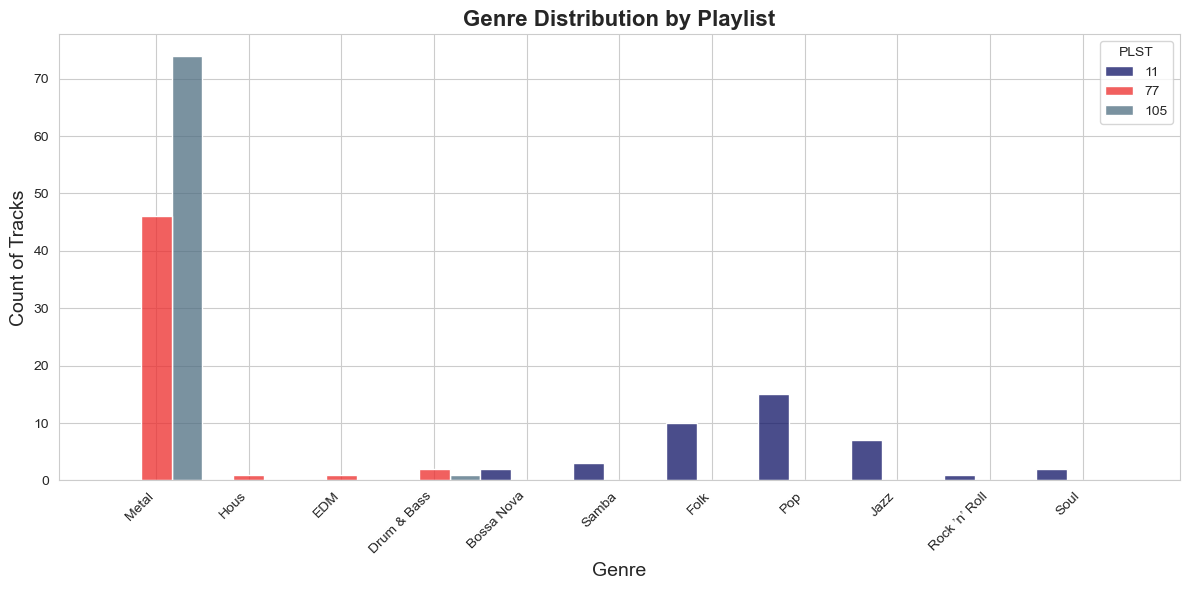

In [ ]:
custom_palette = ["#0D1164", "#ED2B2A", "#4E6E81"]

plt.figure(figsize=(12, 6), facecolor=None) 
sns.set_style("whitegrid") 
sns.histplot(
    data=plst_analysis_146_df,
    x="Genre",
    hue="PLST",
    palette=custom_palette,  
    multiple="dodge", 
)

plt.gca().set_facecolor('none')

plt.title("Genre Distribution by Playlist", fontsize=16, fontweight='bold')
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Count of Tracks", fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('genre_distribution_146.png', transparent=True)

plt.show()